In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [41]:
data = pd.read_csv('game_log.csv')
data

,16,10,15,10.1,6,19,1,2,1.1,10.2,...,45,45.1,1.3,0.2,0.3,True.3,False.5,False.6,4.692,UP
0,16,7,16,8,6,19,1,2,1,7,...,48,48,1.0,0,0,True,False,False,4.970,UP
1,16,3,16,4,6,19,1,2,1,3,...,52,52,1.0,0,0,True,False,False,5.363,UP
2,16,0,16,1,6,19,1,2,1,0,...,55,55,1.0,0,0,True,False,False,5.667,UP
3,16,15,16,16,6,19,4,2,1,15,...,80,80,1.0,0,0,True,False,False,8.108,RIGHT
4,4,15,3,15,6,19,1,2,1,15,...,88,88,1.0,0,0,True,False,False,8.923,UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,16,13,17,5,15,3,1,54,53,13,...,2794,2794,1.0,0,0,True,False,False,285.456,UP
946,16,3,6,6,15,3,3,54,53,3,...,2804,2804,1.0,0,0,True,False,False,286.468,LEFT
947,4,3,3,10,13,0,3,55,54,3,...,2815,2815,1.0,0,0,True,False,False,287.704,LEFT
948,1,3,6,10,13,0,2,55,54,3,...,2818,2818,1.0,0,0,True,False,False,287.942,DOWN


In [58]:
first_rows = np.array(data.iloc[0])
first_rows
for i in first_rows:
    print(type(i))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.float64'>
<class 'str'>


In [73]:

# Identify categorical columns
categorical_cols = []

# Identify numeric columns
numeric_cols = []

for i in range(len(first_rows)-1):
    if(type(first_rows[i]) == str or type(first_rows[i])== np.bool_):
        categorical_cols.append(i)
    else:
        numeric_cols.append(i)

categorical_cols
for i in categorical_cols:
    print(first_rows[i])



False
True
False
False
False
True
True
False
True
False
False


In [74]:
# Separate features and target
X = data.iloc[:, :-1]  # All columns except the last one (features)
y = data.iloc[:, -1]   # The last column (target)
y

0         UP
1         UP
2         UP
3      RIGHT
4         UP
       ...  
945       UP
946     LEFT
947     LEFT
948     DOWN
949     LEFT
Name: UP, Length: 950, dtype: object

In [75]:
len(data.columns)

40

In [76]:
# Define preprocessing for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),  # Normalize numerical features
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical features
    ],
    remainder='passthrough'  # Pass through other columns unchanged
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
print(X_preprocessed)

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42)



[[0.84210526 0.36842105 0.84210526 ... 1.         1.         1.        ]
 [0.84210526 0.15789474 0.84210526 ... 1.         1.         1.        ]
 [0.84210526 0.         0.84210526 ... 1.         1.         1.        ]
 ...
 [0.21052632 0.15789474 0.15789474 ... 1.         1.         1.        ]
 [0.05263158 0.15789474 0.31578947 ... 1.         1.         1.        ]
 [0.05263158 0.31578947 0.31578947 ... 1.         1.         1.        ]]
[3 3 3 2 3 3 2 2 0 2 3 2 3 1 0 2 0 1 3 2 0 1 0 2 3 1 3 1 0 2 0 1 3 2 0 2 3
 1 3 2 0 1 0 2 3 1 0 2 0 1 0 2 3 1 0 1 3 2 0 2 3 1 3 2 0 3 2 0 2 3 1 3 2 0
 1 3 2 0 2 3 2 0 2 0 2 3 2 0 1 3 1 3 2 0 2 3 1 3 1 0 2 3 1 0 1 3 1 3 2 3 1
 0 2 0 1 3 2 3 1 0 2 3 2 0 1 3 3 2 0 1 3 2 0 1 0 1 0 2 3 1 0 2 3 1 0 3 2 0
 1 0 2 1 3 3 3 1 0 1 3 1 0 1 2 3 2 0 1 3 3 2 0 2 3 1 0 2 3 1 0 2 0 1 3 2 0
 1 2 3 1 0 2 3 1 3 2 0 0 1 3 2 0 1 3 1 2 3 1 0 1 3 2 3 3 2 0 2 0 1 1 3 2 0
 2 0 1 0 2 3 2 3 1 0 1 0 2 3 1 0 2 0 3 2 0 1 3 1 0 2 3 1 0 2 2 3 2 0 1 3 1
 3 2 3 1 3 2 0 1 3 2 0 1 3 2 0 

In [81]:
# Define the neural network model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(62, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Adjust for number of unique target classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



/home/vivekup3424/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [82]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2589 - loss: 1.3841 - val_accuracy: 0.3026 - val_loss: 1.3854
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2634 - loss: 1.3861 - val_accuracy: 0.3026 - val_loss: 1.3853
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2441 - loss: 1.3869 - val_accuracy: 0.3026 - val_loss: 1.3861
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2433 - loss: 1.3860 - val_accuracy: 0.3026 - val_loss: 1.3857
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2666 - loss: 1.3862 - val_accuracy: 0.3026 - val_loss: 1.3845
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2620 - loss: 1.3862 - val_accuracy: 0.3026 - val_loss: 1.3845
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2665 - loss: 1.3860 - val_accuracy: 0.3026 - val_loss: 1.3853
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2741 - loss: 1.3855 - val_accuracy: 0.3026 - val_los

In [83]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Output performance metrics
print("Performance Metrics:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Performance Metrics:
              precision    recall  f1-score   support

        DOWN       0.00      0.00      0.00        42
        LEFT       0.19      1.00      0.33        37
       RIGHT       0.00      0.00      0.00        58
          UP       0.00      0.00      0.00        53

    accuracy                           0.19       190
   macro avg       0.05      0.25      0.08       190
weighted avg       0.04      0.19      0.06       190



/home/vivekup3424/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vivekup3424/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vivekup3424/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


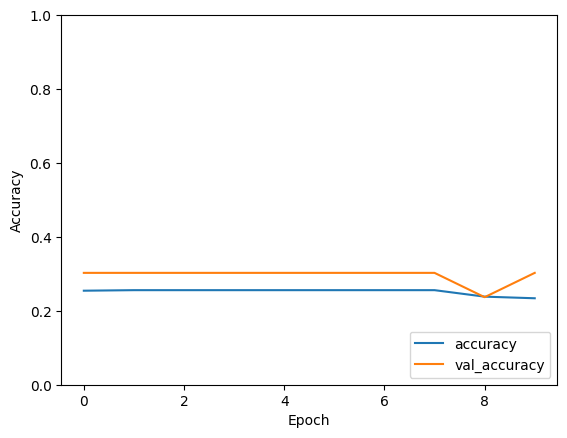

In [84]:
# Plot training history if needed
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()